In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import create_dir
from geo_tool import Point_Cloud

from tf_lab.in_out.basics import Data_Splitter, read_saved_epochs
from tf_lab.point_clouds.ae_templates import mlp_architecture_ala_iclr_18, default_train_params

from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.iclr.helper import load_multiple_version_of_pcs
from tf_lab.neural_net import MODEL_SAVER_ID

from tf_lab.evaluate.generative_pc_nets import entropy_of_occupancy_grid, jensen_shannon_divergence
from tf_lab.nips.helper import pclouds_centered_and_half_sphere

from tf_lab.point_clouds.raw_gan import RawGAN

from tf_lab.point_clouds.generators_discriminators import mlp_discriminator, point_cloud_generator,\
leaky_relu

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
save_model = False
do_training = True
plot_train_curve = False
save_synthetic_samples = np.hstack([np.array([1, 5, 10]), np.arange(50, 2001, 50)])
class_name = raw_input('Give me the class type.\n').lower()
syn_id = snc_category_to_synth_id()[class_name]
# synthetic_data_out_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/synthetic_samples/r_gan/'
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space//DATA/OUT/iclr/synthetic_samples/r_gan/'

Give me the class type.
car


In [5]:
n_pc_points = 2048
max_epochs = 2000
arch_tag = 'mlp_pc_gen_default_leak_20'

leak = 0.2
adaptive_training = None
beta = 0.5

discriminator = mlp_discriminator
generator = point_cloud_generator

batch_size = 50
noise_params = {'mu':0, 'sigma': 0.2}
noise_dim = 128
init_lr = 0.0001

disc_kwargs = {'non_linearity': leaky_relu(leak), 'b_norm': False}
gen_kwargs = {'b_norm': False}

experiment_name = class_name + '_'+ arch_tag + '_raw_gan_' + str(n_pc_points) +  '_pts'

In [6]:
in_data = load_multiple_version_of_pcs('uniform_one', syn_id, n_classes=1)

751 pclouds were loaded. They belong in 1 shape-classes.
6372 pclouds were loaded. They belong in 1 shape-classes.
374 pclouds were loaded. They belong in 1 shape-classes.


In [7]:
training_data = in_data['train']
n_syn_samples = training_data.num_examples  # Same number as original GT data.

In [8]:
reset_tf_graph()

gan = RawGAN(experiment_name, init_lr, [n_pc_points, 3], noise_dim,
             discriminator, generator, beta=beta, gen_kwargs=gen_kwargs, disc_kwargs=disc_kwargs)

accum_syn_data = []
train_stats = []

1 (1.3724586466165978, 0.70457048350431783) 29.4001970291


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


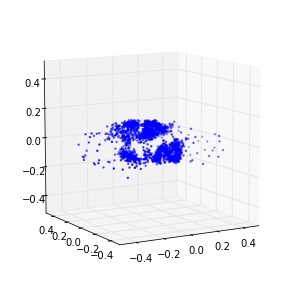

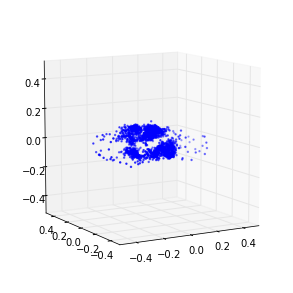

2 (1.3859718690706988, 0.69576705253030369) 29.3297178745
3 (1.385863854190496, 0.69520025647531347) 29.5742921829
4 (1.3854360411486288, 0.69680756142758948) 30.3081688881
5 (1.3851653834966224, 0.69707961345282121) 29.337048769


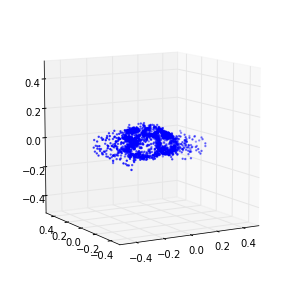

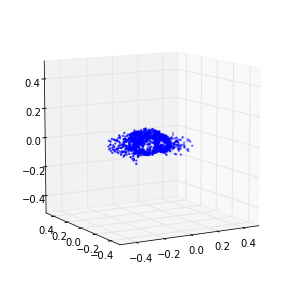

6 (1.3849176459425077, 0.69871334250517714) 29.5542650223
7 (1.3849979329296922, 0.69875627192925283) 29.7642278671
8 (1.3836561985841886, 0.70004736579309301) 29.50613904
9 (1.382275689305283, 0.70420008663117417) 29.6186068058
10 (1.3763321553628276, 0.71008369303125096) 30.340941906


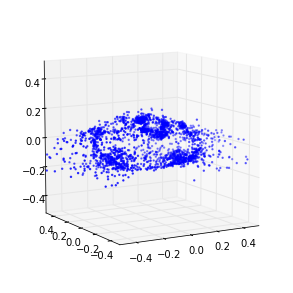

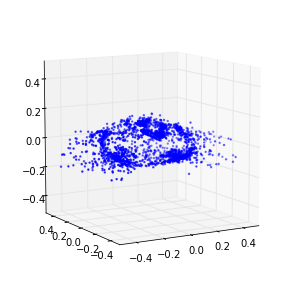

11 (1.3682850787020104, 0.72432212707564592) 29.855381012
12 (1.3512302421209381, 0.76107200956720067) 29.769204855
13 (1.3154105605102899, 0.8124450684532406) 29.7565250397
14 (1.2658045714295756, 0.91968610108368043) 29.9452719688
15 (1.1537390933262082, 1.0391438439136416) 29.9141099453
16 (1.0722126956061115, 1.1693918254431777) 30.3018548489
17 (0.95637053955258344, 1.3324315411838021) 29.9942259789
18 (0.91371749470553065, 1.4746464293772781) 29.9170589447
19 (0.97444040474929206, 1.4316450319890901) 29.5351390839
20 (0.84332272480791948, 1.4414527021993802) 29.8740940094
21 (0.75056245664911947, 1.7717789955965177) 29.8213980198
22 (0.73171709677365826, 1.7305407918344333) 30.0490248203
23 (0.67676560498598048, 1.816468390423482) 30.1116390228
24 (0.60069119003344706, 2.3583930345970816) 29.9760510921
25 (1.3136041708818571, 1.2281939790943477) 29.7564508915
26 (0.96026219627049969, 1.3497188269622682) 29.6958360672
27 (0.87969442779623619, 1.502507629356985) 30.0342919827
28 (0

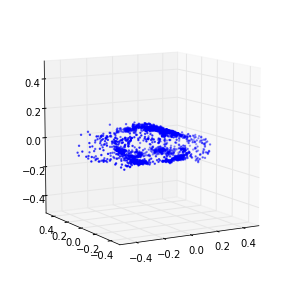

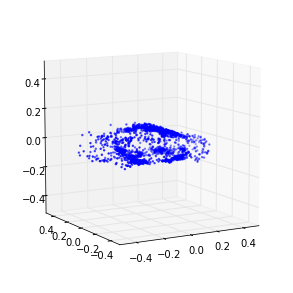

51 (0.64048045122717312, 2.1468503841264979) 29.8100011349
52 (0.56836726745282573, 2.1934344205330678) 29.9577209949
53 (0.47926504675328263, 2.278535151106166) 30.3796570301
54 (0.66662074801490068, 2.3729535266170352) 30.6489679813
55 (0.8143885030051855, 1.8630154848568083) 29.7812440395
56 (0.47015979264195512, 2.080314899992755) 30.0265598297
57 (0.80836019647403023, 2.2352190139725452) 29.8556988239
58 (0.64896640533537375, 1.848417967323243) 30.3135080338
59 (0.62279837537468885, 2.2052933597189237) 30.2524130344
60 (0.67586908964660219, 2.1842128512427563) 29.8756349087
61 (0.62760415039663242, 2.0380729354742004) 30.1587002277
62 (0.62448209970016177, 1.9749936452062111) 29.840939045
63 (0.63101060711962031, 2.302408033703256) 30.0490040779
64 (0.46099312239744533, 2.2180563403865485) 29.749119997
65 (0.6288056892203534, 2.2449074784132441) 30.1178531647
66 (0.64858574942340996, 2.2901774597918894) 29.8812460899
67 (0.48922897370781487, 2.4182736404298799) 29.6506381035
68 (0

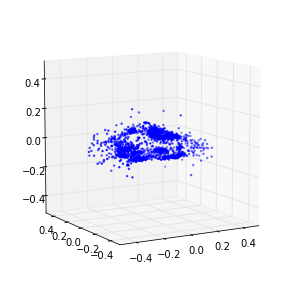

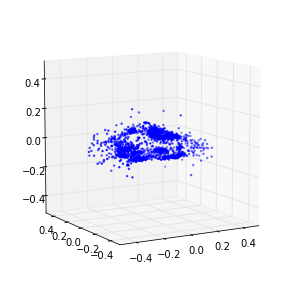

101 (0.28293667595804206, 3.4123154230943813) 29.398414135
102 (0.29251889931404684, 3.0439050178828202) 30.1131429672
103 (0.73278021202312682, 3.0176143653280154) 29.7550690174
104 (0.41486417513898038, 2.4626166585862168) 29.8007569313
105 (0.28692849426288303, 2.871065738632923) 30.0538620949
106 (0.33860888619591872, 3.1034528106216372) 29.8991320133
107 (0.20902805411674846, 3.3560317595173994) 29.9987010956
108 (0.4919677876581357, 3.0937703221332371) 29.8517010212
109 (0.46092179716806714, 3.0919522281706802) 30.5341930389
110 (0.34140652796532228, 3.2370848158213099) 29.7392680645
111 (0.48491605811231719, 2.7070715281907027) 29.6745388508
112 (0.24397444296774901, 3.1760533775870257) 29.8738739491
113 (0.23137116760719478, 3.187839664812163) 30.0522668362
114 (0.2220279447822355, 3.8140229681345423) 30.4024260044
115 (0.47053736630152532, 3.0749972814650048) 29.6884171963
116 (0.25497692662078564, 3.1473873905309544) 29.9103229046
117 (1.1561446902085477, 2.7872237654652183) 

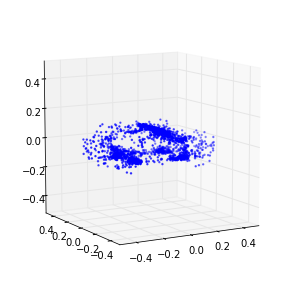

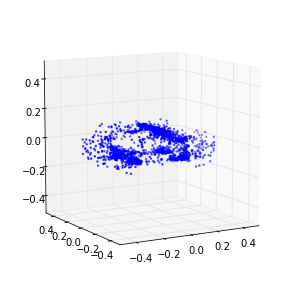

151 (0.44451593666330097, 2.5632642836082637) 29.6965241432
152 (0.63514278359769838, 2.3779275853802839) 29.8731780052
153 (0.55497325100298001, 2.515415577907262) 30.305590868
154 (0.68060028670341011, 2.2146772338649421) 29.6622810364
155 (0.85055049467743848, 2.0154819941426827) 30.2031998634
156 (0.65743734177172652, 2.0488384295636273) 29.6289079189
157 (1.0634110661472862, 1.4000470572569239) 30.0505139828
158 (0.61818386614322662, 2.0035075700189187) 30.193048954
159 (0.62292372171334398, 1.8729395594183855) 29.8704240322
160 (0.55643895244973851, 2.1364345278326922) 30.0496058464
161 (0.87169478493412644, 1.6283656061868967) 29.5917918682
162 (0.44352783556059588, 2.1856315492645022) 30.6837480068
163 (0.68433433536469468, 2.0443847158293087) 29.542345047
164 (0.31196334130886033, 2.4659880770473031) 29.9101560116
165 (0.45358990358672741, 2.9728237061988652) 29.5744960308
166 (1.1270112540778212, 1.2829336526356345) 29.8385999203
167 (0.81717617281778587, 1.5142911789924141) 

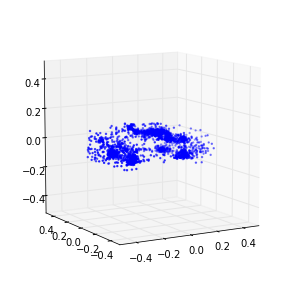

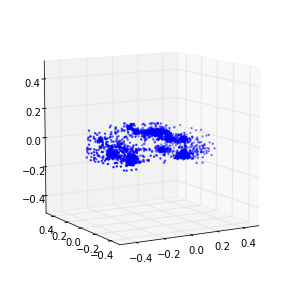

201 (0.62705038194581275, 1.9608809577198478) 30.2514939308
202 (0.64449042316496841, 1.8784063411509897) 30.4715669155
203 (0.61066835549638032, 2.2673868860785418) 31.5630078316
204 (0.93531965106491033, 1.4143056677082393) 30.5949370861
205 (0.50259396363431075, 2.1177752534235554) 30.4493451118
206 (0.75746556213052252, 1.9553289915633014) 30.5649020672
207 (0.53749056629777892, 2.1319064380615713) 30.424738884
208 (0.83037982622938833, 1.9965596166182691) 29.789796114
209 (0.8779413125177068, 1.2950840934993715) 30.3351590633
210 (0.52922260902059359, 2.2993021898382291) 30.8312759399
211 (0.51715057431243538, 2.1338008064923324) 30.2850399017
212 (0.46916937024339916, 2.7263719444199812) 30.4167289734
213 (0.73942153343534844, 1.6953434418505571) 30.5124480724
214 (0.53006937407602472, 2.23972192148524) 30.3849840164
215 (0.74892802929549707, 2.5200708128335907) 30.2674970627
216 (0.40863825286936573, 2.0543311177276249) 31.1430931091
217 (0.43960197249383437, 3.2554638423318938)

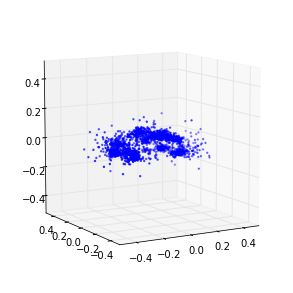

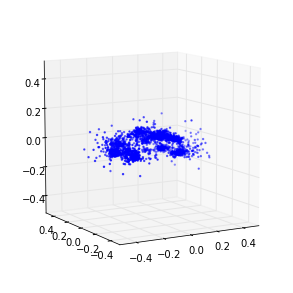

251 (0.81586297290531673, 1.6915814881249676) 29.6602959633
252 (0.38804976372268257, 2.2369407340297549) 30.0011339188
253 (0.29357037898593064, 3.2232951310675912) 29.6062831879
254 (0.63846366664790732, 1.9872332069817491) 29.6232819557
255 (0.05909235737337841, 3.3527164440455399) 30.0583791733
256 (0.028876906994172908, 3.8429682142152561) 29.6401519775
257 (0.019318974261560779, 4.3410377051886613) 29.9733231068
258 (0.010795956666354002, 5.3198319082185037) 29.678841114
259 (0.063367539921438135, 5.4620152195607581) 29.5940721035
260 (0.63201040190857227, 4.2048435726269027) 29.7856538296
261 (0.68967526024720804, 2.6068788225960544) 29.8441910744
262 (0.71835459170379035, 2.5930721496972513) 29.6404259205
263 (0.62636436299076226, 2.3101726277606693) 29.6199629307
264 (0.49972531058656888, 2.5528128888663346) 29.5494110584
265 (0.59374205122782486, 2.6430255540712611) 29.7514178753
266 (0.50924396069031064, 2.717456276491871) 29.5865631104
267 (0.5970450723030436, 2.32363617514

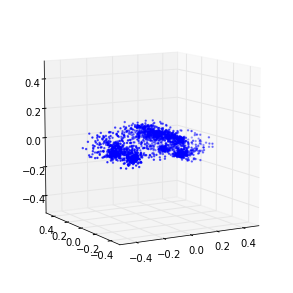

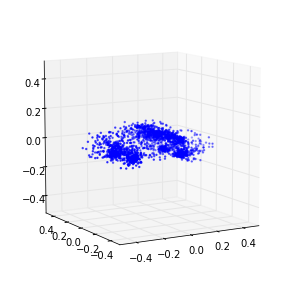

301 (0.26821445283575318, 2.683390583578996) 29.5303618908
302 (0.015681619583592404, 4.5547256770096425) 29.5409200191
303 (0.089003018011874338, 4.899490463452076) 29.7731070518
304 (1.2929688800038315, 3.2827729413828513) 29.7093100548
305 (0.55962192801039989, 2.1997526630641908) 29.7705230713
306 (0.6034943909626308, 2.4134730769423989) 29.7009470463
307 (0.55051599677622787, 2.2704983548385891) 29.4424290657
308 (0.5733518488998488, 2.4630244979708213) 29.6200528145
309 (0.5212949655187411, 2.3922142466222209) 29.5551421642
310 (0.43132377351362872, 2.5822789875541146) 29.7409350872
311 (0.61424313180559265, 2.3746821899113693) 29.7327210903
312 (0.43835933048894088, 2.7070015105675527) 29.6155841351
313 (0.37723430645043454, 2.8618172313284687) 29.7669949532
314 (0.37268704351947063, 3.0268241214001272) 29.92517519
315 (0.57953702852012601, 2.6401645100022866) 29.7963671684
316 (0.54716637953529212, 2.2957826909117811) 29.7325119972
317 (0.47505902997621402, 2.7632823164068809) 

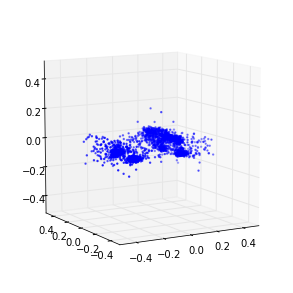

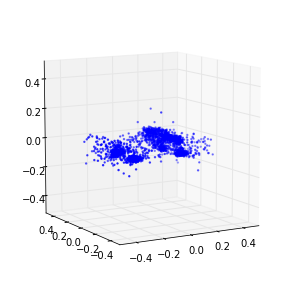

351 (0.2159543168973031, 3.2602147586702364) 29.5473539829
352 (0.066851629750935115, 3.7483336850414126) 29.6106901169
353 (0.74028457323543906, 4.7481580867072726) 29.4861340523
354 (0.95195618248361302, 1.2491992378798056) 29.805232048
355 (0.42603776196208526, 2.12133963230088) 29.7018201351
356 (0.54568728082996654, 2.7357268239569477) 29.7876639366
357 (0.33725572958236605, 2.6334183760515346) 29.6562459469
358 (0.35609410984778966, 3.0605183576974344) 30.1699068546
359 (0.98075460284713689, 2.0476807848675045) 29.4433131218
360 (0.27740064266277109, 2.4973842628358858) 29.6461119652
361 (0.51996597147539381, 3.914710750730019) 29.5390651226
362 (0.56659411198980225, 1.9848754222937457) 29.4934229851
363 (0.25881834639104334, 2.5942773208843439) 29.9742510319
364 (0.37742107024225663, 2.977644246863568) 29.5587830544
365 (0.071343541497320639, 3.7862051115261286) 29.7722599506
366 (0.015104038659189864, 4.9934091680631862) 29.4560520649
367 (0.063252752760469211, 5.03648734655905

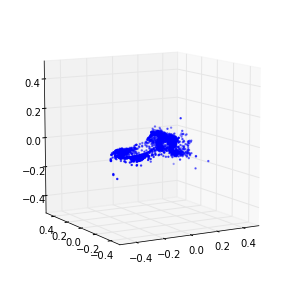

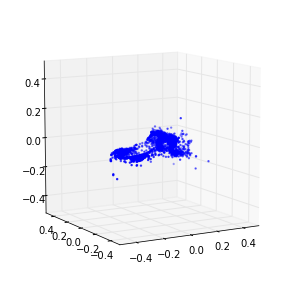

401 (0.011845978468245878, 4.4801804775328149) 29.3225669861
402 (0.0038129946044609536, 5.7881730222326562) 29.6274578571
403 (0.0057456534178047551, 6.2204780353335885) 29.5335540771
404 (0.3343957360590053, 6.396486301385746) 29.6401019096
405 (0.27418831390453369, 4.2636037953491286) 29.3320291042
406 (0.39368493582202696, 4.0221094184034456) 29.5461390018
407 (0.51574578326870135, 3.9403735615137054) 29.5932850838
408 (0.38140553394405863, 3.284325495010286) 29.4604449272
409 (0.55154263163645434, 3.2734869605912937) 29.5660510063
410 (0.47393505146184306, 3.150217148028021) 29.7743999958
411 (0.4639790839566959, 2.9620321791941726) 29.4221367836
412 (0.5589020208814951, 3.2551109131396285) 29.7688009739
413 (0.58531661495918363, 2.9192808850074377) 29.8396580219
414 (0.41480434597946525, 2.9398402304161251) 29.5793340206
415 (0.38762404928057215, 3.1444947156380483) 29.7443940639
416 (0.41342115161691123, 3.4382392027246671) 29.5915410519
417 (0.30659226647864174, 3.0173963815208

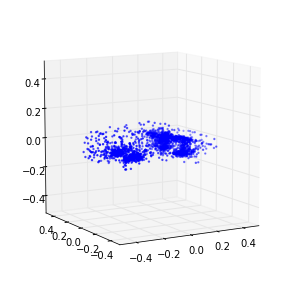

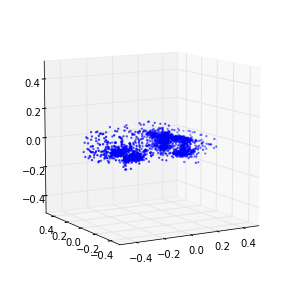

451 (0.28767877611822967, 3.2580317676536681) 29.4400238991
452 (0.22254208252420576, 3.6196463896533637) 29.3547399044
453 (0.27749254749574531, 3.5144090742811445) 29.6254169941
454 (0.18939496915582127, 3.467424191827849) 29.7604110241


KeyboardInterrupt: 

In [9]:
save_syn_data_dir = create_dir(osp.join(synthetic_data_out_dir, experiment_name))

if do_training:
    for _ in range(max_epochs):
        loss, duration = gan._single_epoch_train(training_data, batch_size, noise_params, adaptive=adaptive_training)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss, duration
        if save_model and epoch % 10 == 0:
            checkpoint_path = osp.join(train_dir, model_saver_id)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
            
        if epoch in save_synthetic_samples:
            syn_data = gan.generate(n_syn_samples, noise_params)
            accum_syn_data.append(syn_data)
            np.savez(osp.join(save_syn_data_dir, 'epoch_' + str(epoch)), syn_data)            
            for k in range(2):
                Point_Cloud(syn_data[k]).plot()
        train_stats.append((epoch,) + loss)

In [ ]:
if plot_train_curve:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('Latent GAN training. (%s, %s)' %(class_name, ae_loss))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')